# Ocean Circulation Diagnostics

### Import modules

In [1]:
import sys
#sys.path.insert(0, '../..')
from IPython import get_ipython
from IPython.lib.deepreload import reload

%load_ext autoreload
%autoreload 2
from aqua import Reader,catalogue, inspect_catalogue
from ocean3d import load_obs_data
from ocean3d import check_variable_name
from ocean3d import stratification
from ocean3d import plot_spatial_mld_clim 
from aqua.util import load_yaml

### Load Model Data 

This block is to load the data of a model (chosen from the catalog as an example )


In [2]:
reader = Reader(model='IFS-NEMO', exp='historical-1990', source="lra-r100-monthly")

data = reader.retrieve(startdate= "1997", enddate= "2000")
data = check_variable_name(data)


2024-05-20 22:45:04 :: Reader :: WARNING  -> DATA_PATH parameter is required but is missing, setting to default /pfs/lustrep3/projappl/project_465000454/data/AQUA/datasets
2024-05-20 22:45:05 :: Reader :: WARNING  -> The requested default fixer name IFS-NEMO-default does not exist in fixes files
2024-05-20 22:45:05 :: Reader :: WARNING  -> No fixes available for model IFS-NEMO, experiment historical-1990, source lra-r100-monthly


2024-05-20 22:45:10 :: Unit :: WARNING  -> The unit of Pot. Temperature is Kelvin. Converting to degC


In [3]:
data

<xarray.Dataset> Size: 4GB
Dimensions:     (time: 48, lev: 75, lat: 180, lon: 360)
Coordinates:
  * time        (time) datetime64[ns] 384B 1997-01-01 1997-02-01 ... 2000-12-01
  * lat         (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon         (lon) float64 3kB 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * lev         (lev) float64 600B 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    idx_level   (lev) int64 600B dask.array<chunksize=(75,), meta=np.ndarray>
Data variables:
    avg_so      (time, lev, lat, lon) float64 2GB dask.array<chunksize=(12, 75, 180, 360), meta=np.ndarray>
    avg_thetao  (time, lev, lat, lon) float64 2GB dask.array<chunksize=(12, 75, 180, 360), meta=np.ndarray>
Attributes:
    history:  \n2024-05-20 22:45:10 AQUA💧: Retrieved from IFS-NEMO_historical...

### Load Observation Data

In [4]:
obs_data = load_obs_data(model='EN4', exp='en4', source='monthly')
obs_data = check_variable_name(obs_data)


2024-05-20 22:45:10 :: Reader :: WARNING  -> DATA_PATH parameter is required but is missing, setting to default /pfs/lustrep3/projappl/project_465000454/data/AQUA/datasets
2024-05-20 22:45:11 :: Reader :: ERROR    -> Variable time_bnds has no units!
2024-05-20 22:45:11 :: Reader :: ERROR    -> Variable lon_bnds has no units!
2024-05-20 22:45:11 :: Reader :: ERROR    -> Variable lat_bnds has no units!
2024-05-20 22:45:11 :: Reader :: ERROR    -> Variable lev_bnds has no units!
2024-05-20 22:45:19 :: Unit :: WARNING  -> The unit of Pot. Temperature is Kelvin. Converting to degC


In [5]:
obs_data

<xarray.Dataset> Size: 19GB
Dimensions:     (time: 876, lev: 42, lat: 180, lon: 360)
Coordinates:
  * lon         (lon) float64 3kB 1.0 2.0 3.0 4.0 ... 357.0 358.0 359.0 360.0
  * lat         (lat) float64 1kB -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0
  * lev         (lev) float32 168B 5.022 15.08 25.16 ... 5.051e+03 5.35e+03
    idx_lev     (lev) int64 336B 0 1 2 3 4 5 6 7 8 ... 34 35 36 37 38 39 40 41
  * time        (time) datetime64[ns] 7kB 1950-01-01 1950-02-01 ... 2022-12-01
Data variables:
    avg_so      (time, lev, lat, lon) float32 10GB dask.array<chunksize=(1, 1, 180, 360), meta=np.ndarray>
    avg_thetao  (time, lev, lat, lon) float32 10GB dask.array<chunksize=(1, 1, 180, 360), meta=np.ndarray>
Attributes: (12/25)
    CDI:                    Climate Data Interface version 2.0.5 (https://mpi...
    Conventions:            CF-1.0
    institution:            UK Met Office
    title:                  Temperature and salinity analysis
    DSD_entry_id:           UKMO-L4UHFnd-GLOB-v01
    references:             Website and paper: https://www.metoffice.gov.uk/h...
    ...                     ...
    easternmost_longitude:  362.5
    file_quality_index:     0
    licence:                EN4 is distributed under the Non Commercial Gover...
    history:                Thu Jun 29 09:47:09 2023: cdo mergetime so_195001...
    NCO:                    netCDF Operators version 4.9.2 (Homepage = http:/...
    CDO:                    Climate Data Operators version 2.0.5 (https://mpi...

In [6]:
o3d_request= {'model':'IFS-NEMO',
'exp':'historical-1990',
'source': 'lra-r100-monthly',
'data': data,
'obs_data': obs_data,
'region':'Labrador Sea',
'latS':None,
'latN':None,
'lonW':None,
'lonE':None,
'output':True,
"time" : "February",
'output_dir':'./output'}

## Functions:

All functions (primary and secondary) can be found in ocean_circulation
First you must have cofig/o3d_request looks like above in order to use this fucntions.

The two primary diagnostic functions are:

### 1. stratification

`stratification(o3d_request)`

This function produces climatological stratification plots over a region in a model dataset and EN4 observations. It produces three lines, one for the whole model simulation, one for the model in the overlap period with EN4, and another for EN4 in the overlap period with the model. If there is no overlap period with observations, EN4 climatology is provided for the period 1950-2022.

It requires you to provide: 
- A file with model data of 3D ocean potential temperature and practical salinity
- A specific region where stratification is computed (or to provide a custom latxlon box instead)
- The temporal resolution over which the climatology is computed (annual, a given season or a given month). 
     
### 2. plot_spatial_mld

`plot_spatial_mld_clim(o3d_request)`

This function computes the mixed layer depth from monthly 3D ocean potential temperature and practical salinity, both for a model simulation and EN4 observations, and plots their climatology. It allows the user to choose if climatologies
are computed over the whole simulated and observed period, or over their overlap periods.

It requires you to provide:
- A file with model data of 3D ocean potential temperature and practical salinity
- A specific latitudinal/longitudinal box over which the MLD is shown
- The temporal resolution over which the climatology is computed (annual, a given season or a given month)

## Example

To plot the climatological MLD in February, fma or the whole year in the Labrador Seas in all cases 
for the overlap period of the Model and Obs datasets we would call plot_spatial_mld_clim as shown below


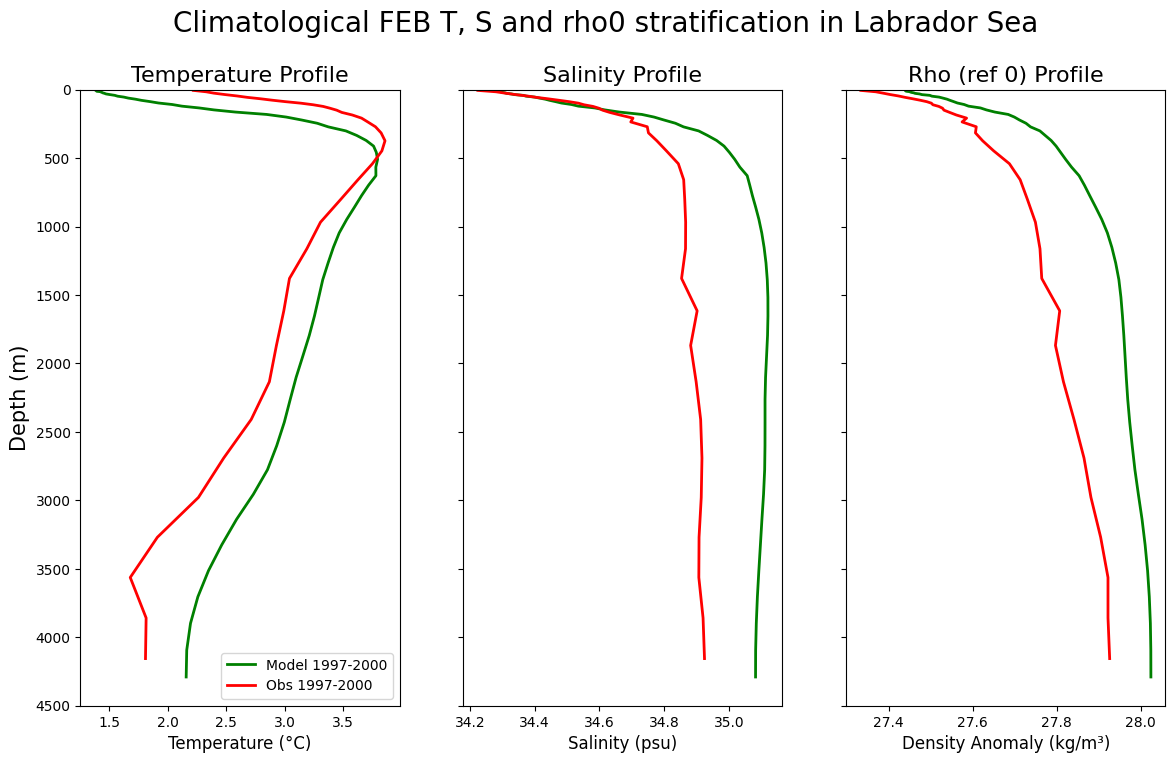

In [7]:
strat = stratification(o3d_request)
strat.plot()

This is an example of how to call thee same function but for the overlap period between OBS and the model, and using yearly means

/opt/conda/lib/python3.12/site-packages/dask/array/reductions.py:654: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


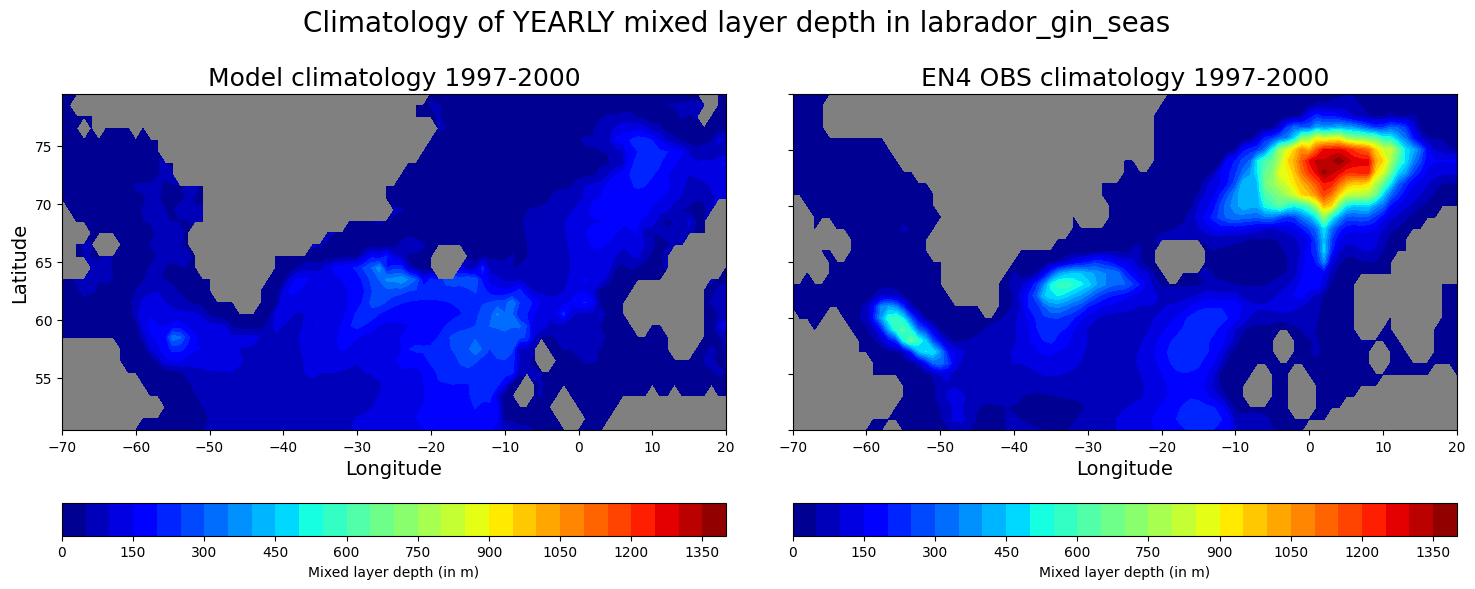

In [8]:
o3d_request["region"] = "labrador_gin_seas"
o3d_request["time"] =  "Y"
plot_spatial_mld_clim(o3d_request)